In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import geopandas as gpd

import cartopy.crs as ccrs
import scipy.stats as stats

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

import shapely.geometry as sg
from shapely.geometry import Point

import sys
sys.path.append(os.path.abspath(".."))
from function import DOWN_raw
from function import ART_preprocessing as ART_pre

import warnings
warnings.filterwarnings('ignore')

In [2]:
# font = 'SAT'
font = 'DOWN'

In [3]:
lon_min, lon_max, lat_min, lat_max, area, toll = 6.5, 19, 36.5, 48, 'ITALY', 0.002

Tr = [5, 10, 20, 50, 100]
Fi = 1 - 1/np.array(Tr)

In [4]:
veneto_dir = os.path.join('/','media','arturo','T9','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    REGIONS = gpd.read_file(os.path.join(veneto_dir,'Italy_regions.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [5]:
obs_base = os.path.join('/','media','arturo','T9','Data','Italy', 'stations', 'Italy_raingauges')
sat_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite','5_DOWN')

In [6]:
METADATA = pd.read_csv(os.path.join(obs_base, 'METADATA', 'METADATA_INTENSE_NOQC_update.csv'))
METADATA.head(2)

,File,ISO,Region,Code,Name,Elevation,Orig_EPSG,CRS_E,CRS_N,Lat,Lon,Year_Start,Year_End,INTENSE_Resp,AGENCY,Source,TimeZone,Agency
0,IT-210_PIE-001030-900_0060.csv,IT-210,Piedmont,PIE-001030-900,BORGOFRANCODIVREA,337.0,32632.0,410005.0,5040731.0,45.514302,7.847798,1988-05-08 05:00:00,2024-09-09 01:00:00,DT,ARPA Piemonte,Piedmont,UTC,NaN
1,IT-210_PIE-001097-900_0060.csv,IT-210,Piedmont,PIE-001097-900,CUMIANA,327.0,32632.0,373092.0,4980177.0,44.963696,7.390821,1988-01-29 03:00:00,2024-09-18 12:00:00,DT,ARPA Piemonte,Piedmont,UTC,NaN


## Load ISO regions and names

In [7]:
ISO_names = pd.read_csv(os.path.join(obs_base,'ISO_IT_REGION.csv'))
ISO_names.head(2)

,REGION,ISO
0,Abruzzo,IT-650
1,Basilicata,IT-770


## Load ENSEMBLE data

In [8]:
dir_in = os.path.join(sat_base,'ITALY_ENSEMBLE_1dy_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson.nc')
data = xr.open_dataset(dir_in)

lat_sat = data.lat.values
lon_sat = data.lon.values
lon2d_sat, lat2d_sat = np.meshgrid(lon_sat, lat_sat)

Sat_year = data.year.values

print(f'Load {font} parameters')
if font == 'SAT':
    Sat_NYd = data.NYs.values
    Sat_CYd = data.CYs.values
    Sat_WYd = data.WYs.values
elif font == 'DOWN':
    Sat_NYd = data.NYd.values
    Sat_CYd = data.CYd.values
    Sat_WYd = data.WYd.values
else:
    print('Font dont found')
    sys.exit()

Load DOWN parameters


## Choose the Region

In [9]:
Tr_index = 3
print(f'Tr: {Tr[Tr_index]} years')

Tr: 50 years


In [10]:
ISO_names["ISO_num"] = ISO_names["ISO"].str.split("-").str[1].astype(int)
ISO_names = ISO_names.sort_values("ISO_num").drop(columns="ISO_num").reset_index(drop=True)
ISO_names.head(5)

,REGION,ISO
0,Piedmont,IT-210
1,Aosta Valley,IT-230
2,Lombardy,IT-250
3,Trentino,IT-321
4,Alto-Adige,IT-322


In [11]:
diccionario_resultados = {}

for rr in range(len(ISO_names)):#len(ISO_names)
    region_ = ISO_names.iloc[rr]['ISO']
    region_label = ISO_names[ISO_names['ISO']==region_]

    print(f'{rr}: {region_label['REGION'].values[0]} ({region_})')

    METADATA_clear = METADATA[METADATA['ISO']==region_].reset_index(inplace=False)

    Q50_OBS, Q50_SAT, RE_50 = [], [], []
    for nn in range(len(METADATA_clear)):#len(METADATA_clear)
        filename = f'{METADATA_clear['File'].values[nn]}'
        lat_obs = METADATA_clear['Lat'][nn]
        lon_obs = METADATA_clear['Lon'][nn]

        OBS_pd = pd.read_csv(os.path.join(obs_base, 'DATA_1dy', 'statistics', region_, filename))
        OBS_pd = OBS_pd[(OBS_pd['Year']>=2002)&(OBS_pd['Year']<=2023)].reset_index(drop=True)
        if len(OBS_pd) == 0:
            continue
        
        else:
            OBS_N = OBS_pd['N'].values
            OBS_C = OBS_pd['C'].values
            OBS_W = OBS_pd['W'].values
            OBS_Y = OBS_pd['Year'].values

            mask = ~np.isnan(OBS_N)

            OBS_N = OBS_N[mask]
            OBS_C = OBS_C[mask]
            OBS_W = OBS_W[mask]
            OBS_Y = OBS_Y[mask]

            if len(OBS_Y) >= 8: # greather than 8 years

                x0 = np.nanmean(OBS_C)
                OBS_Q, flag = DOWN_raw.mev_quant_update(Fi, x0, OBS_N, OBS_C, OBS_W, thresh=1)
                OBS_Q2 = np.where(flag, OBS_Q, np.nan)

                distances = ART_pre.haversine(lat2d_sat, lon2d_sat, lat_obs, lon_obs)
                min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
                Sat_NYd_ = Sat_NYd[:,min_index[0],min_index[1]]
                Sat_CYd_ = Sat_CYd[:,min_index[0],min_index[1]]
                Sat_WYd_ = Sat_WYd[:,min_index[0],min_index[1]]

                Sat_pd = pd.DataFrame({'Year':Sat_year, 'N':Sat_NYd_, 'C':Sat_CYd_, 'W':Sat_WYd_})
                # Sat_pd_filtered = Sat_pd[Sat_pd['Year'].isin(OBS_pd['Year'])].reset_index()
                Sat_pd_filtered = Sat_pd.set_index('Year').loc[OBS_pd['Year']].reset_index()

                SAT_N = Sat_pd_filtered['N'].values
                SAT_C = Sat_pd_filtered['C'].values
                SAT_W = Sat_pd_filtered['W'].values
                SAT_Y = Sat_pd_filtered['Year'].values

                SAT_N = SAT_N[mask]
                SAT_C = SAT_C[mask]
                SAT_W = SAT_W[mask]
                SAT_Y = SAT_Y[mask]

                if len(OBS_Y) != len(SAT_Y):
                    print('ERROR')
                    sys.exit()
                else:
                    x0 = np.nanmean(SAT_C)
                    SAT_Q, flag = DOWN_raw.mev_quant_update(Fi, x0, SAT_N, SAT_C, SAT_W, thresh=1)
                    SAT_Q2 = np.where(flag, SAT_Q, np.nan)

                relative_e_50 = (SAT_Q2[3] - OBS_Q2[3])/OBS_Q2[3]

                Q50_OBS.append(float(OBS_Q2[3]))
                Q50_SAT.append(float(SAT_Q2[3]))
                RE_50.append(float(relative_e_50))

            else:        
                continue

            RE_50_M = np.array(RE_50)
            RE_50_M = RE_50_M[(RE_50_M>-1)&(RE_50_M<1)]
            diccionario_resultados[region_] = RE_50_M

0: Piedmont (IT-210)
1: Aosta Valley (IT-230)
2: Lombardy (IT-250)
3: Trentino (IT-321)
4: Alto-Adige (IT-322)
5: Veneto (IT-340)
6: Friuli Venezia Giulia (IT-360)
7: Liguria (IT-420)
8: Emilia-Romagna (IT-450)
9: Tuscany (IT-520)
10: Umbria (IT-550)
11: Marche (IT-570)
12: Lazio (IT-620)
13: Abruzzo (IT-650)
14: Molise (IT-670)
15: Campania (IT-720)
16: Apulia (IT-750)
17: Basilicata (IT-770)
18: Calabria (IT-780)
19: Sicily (IT-820)
20: Sardinia (IT-880)


In [12]:
df_resultados = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in diccionario_resultados.items()]))
df_resultados.head(3)

,IT-210,IT-230,IT-250,IT-321,IT-322,IT-340,IT-360,IT-420,IT-450,IT-520,...,IT-570,IT-620,IT-650,IT-670,IT-720,IT-750,IT-770,IT-780,IT-820,IT-880
0,-0.594264,-0.185368,-0.480730,-0.453034,0.128879,-0.192248,-0.308240,-0.513254,-0.407064,-0.109162,...,-0.192085,-0.137720,-0.213628,-0.480007,-0.128790,-0.299132,-0.160961,-0.255083,0.387044,-0.068962
1,-0.675450,-0.111064,-0.116676,-0.375014,-0.082933,-0.220102,-0.228782,0.145306,-0.397212,-0.433870,...,-0.219965,-0.145754,-0.109540,-0.663926,-0.178921,-0.460616,-0.298799,0.011159,-0.239543,0.338662
2,-0.725924,-0.269801,-0.132547,-0.122315,-0.247518,-0.250303,-0.212561,-0.175463,-0.332385,-0.196257,...,0.192069,-0.114659,-0.244558,-0.493119,-0.280084,-0.380506,0.063010,0.182179,0.541850,-0.409077


In [13]:
dir_out = os.path.join(obs_base, f'{font}_relative_error.csv')
print(f'Export as: {dir_out}')
df_resultados.to_csv(dir_out, header=True, index=False)

Export as: /media/arturo/T9/Data/Italy/stations/Italy_raingauges/DOWN_relative_error.csv


## Se debe fusionar Alto-Adige (IT-322) y Trentino (IT-321) para Trentino-Alto (IT-32)

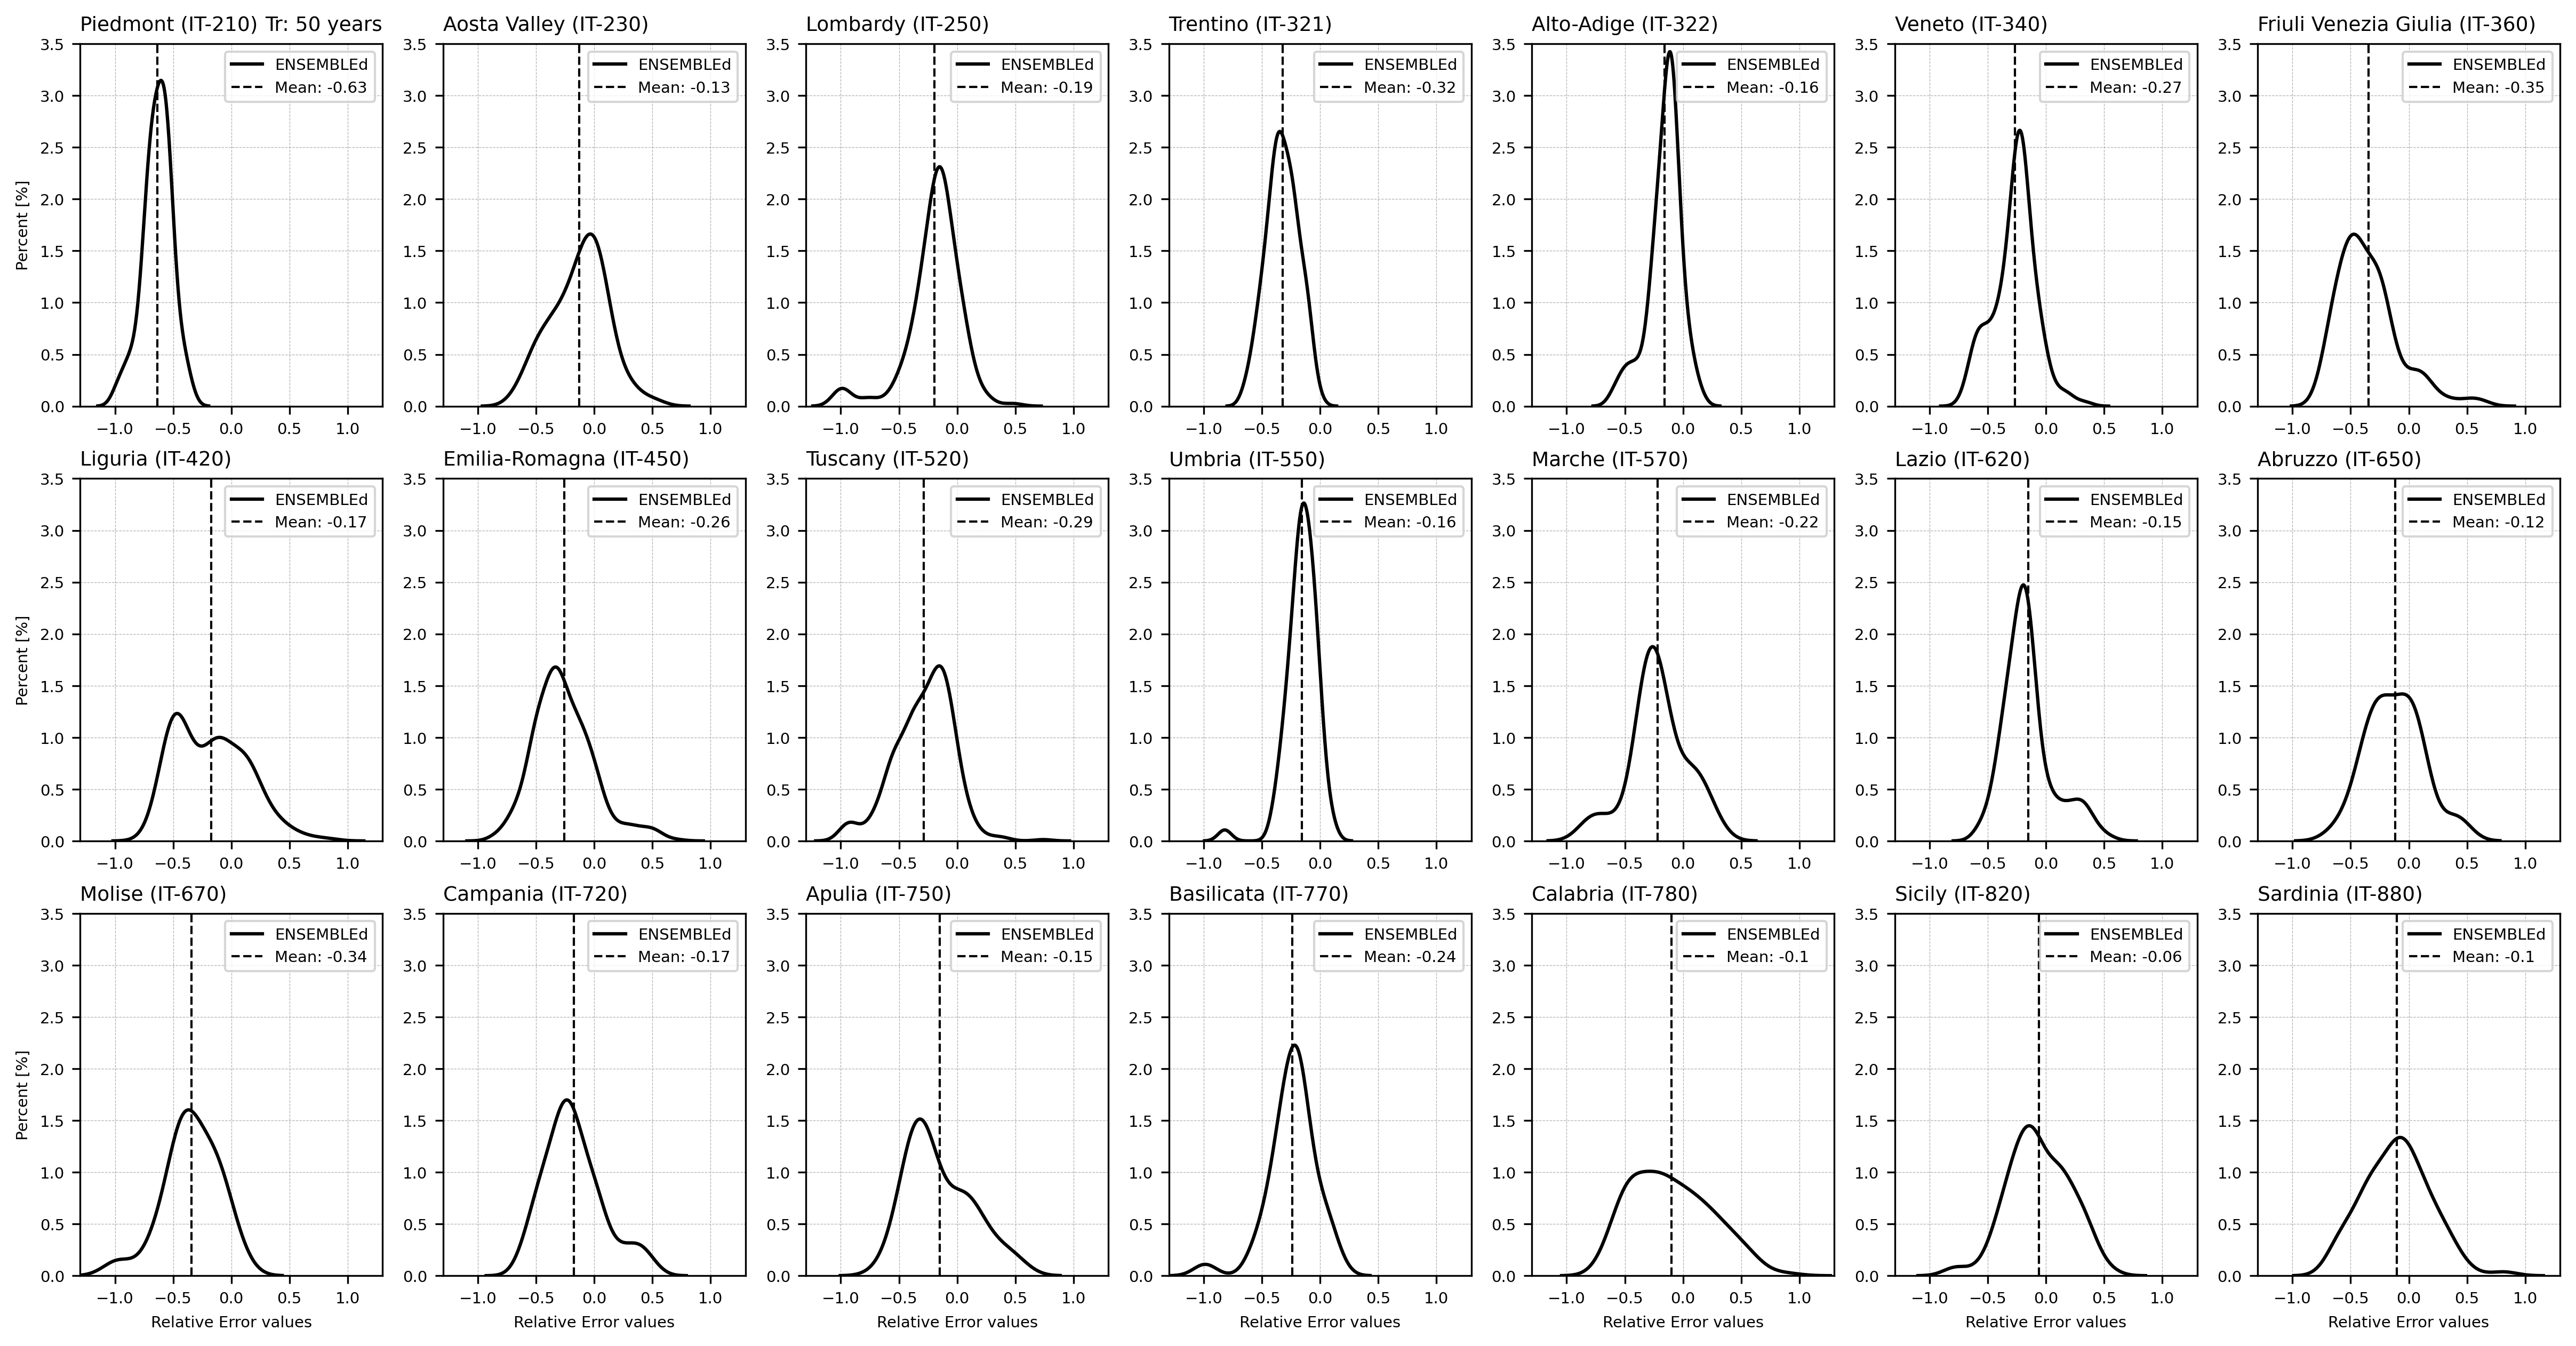

In [14]:
dict_keys = list(diccionario_resultados.keys())

fig = plt.figure(figsize=(20,10),dpi=300)
gs = gridspec.GridSpec(3,7)

pos = 0
for nrow in range(3):
    for ncol in range(7):
        ax1 = plt.subplot(gs[nrow, ncol])
        region_mean = np.round(np.nanmean(diccionario_resultados[dict_keys[pos]]),2)
        sns.kdeplot(diccionario_resultados[dict_keys[pos]],color='k',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ENSEMBLEd')
        ax1.axvline(np.nanmean(diccionario_resultados[dict_keys[pos]]),color='k',linestyle='--',linewidth=1, label=f'Mean: {region_mean}')

        ax1.set_xlim(-1.3,1.3)
        ax1.set_ylim(0,3.5)
        ax1.legend(fontsize=7, loc=0, ncol=1)
        ax1.grid(linewidth=0.3, linestyle='--')
        ax1.tick_params(axis='both', which='major', labelsize=7)
        
        if ncol == 0:
            ax1.set_ylabel('')
            ax1.set_ylabel('Percent [%]',fontsize=7)
            if nrow == 0:
                ax1.set_title(f'Tr: {Tr[Tr_index]} years', fontsize=9, loc='right')
        else:
            ax1.set_ylabel('')

        if nrow == 2:
            ax1.set_xlabel('Relative Error values',fontsize=7) 

        region_l = ISO_names[ISO_names['ISO']==dict_keys[pos]].values[0][0]
        ISO_l = ISO_names[ISO_names['ISO']==dict_keys[pos]].values[0][1]
        ax1.set_title(f'{region_l} ({ISO_l})', fontsize=9, loc='left')

        pos += 1

In [15]:
R_mean, R_max, R_min = [], [], []
for nn in range(len(ISO_names)):
    R_mean.append(np.round(np.nanmean(diccionario_resultados[dict_keys[nn]]),2))
    R_max.append(np.round(np.nanmax(diccionario_resultados[dict_keys[nn]]),2))
    R_min.append(np.round(np.nanmin(diccionario_resultados[dict_keys[nn]]),2))

ISO_names["mean"] = R_mean
ISO_names["max"] = R_max
ISO_names["min"] = R_min

Text(0.5, 0, 'Regions')

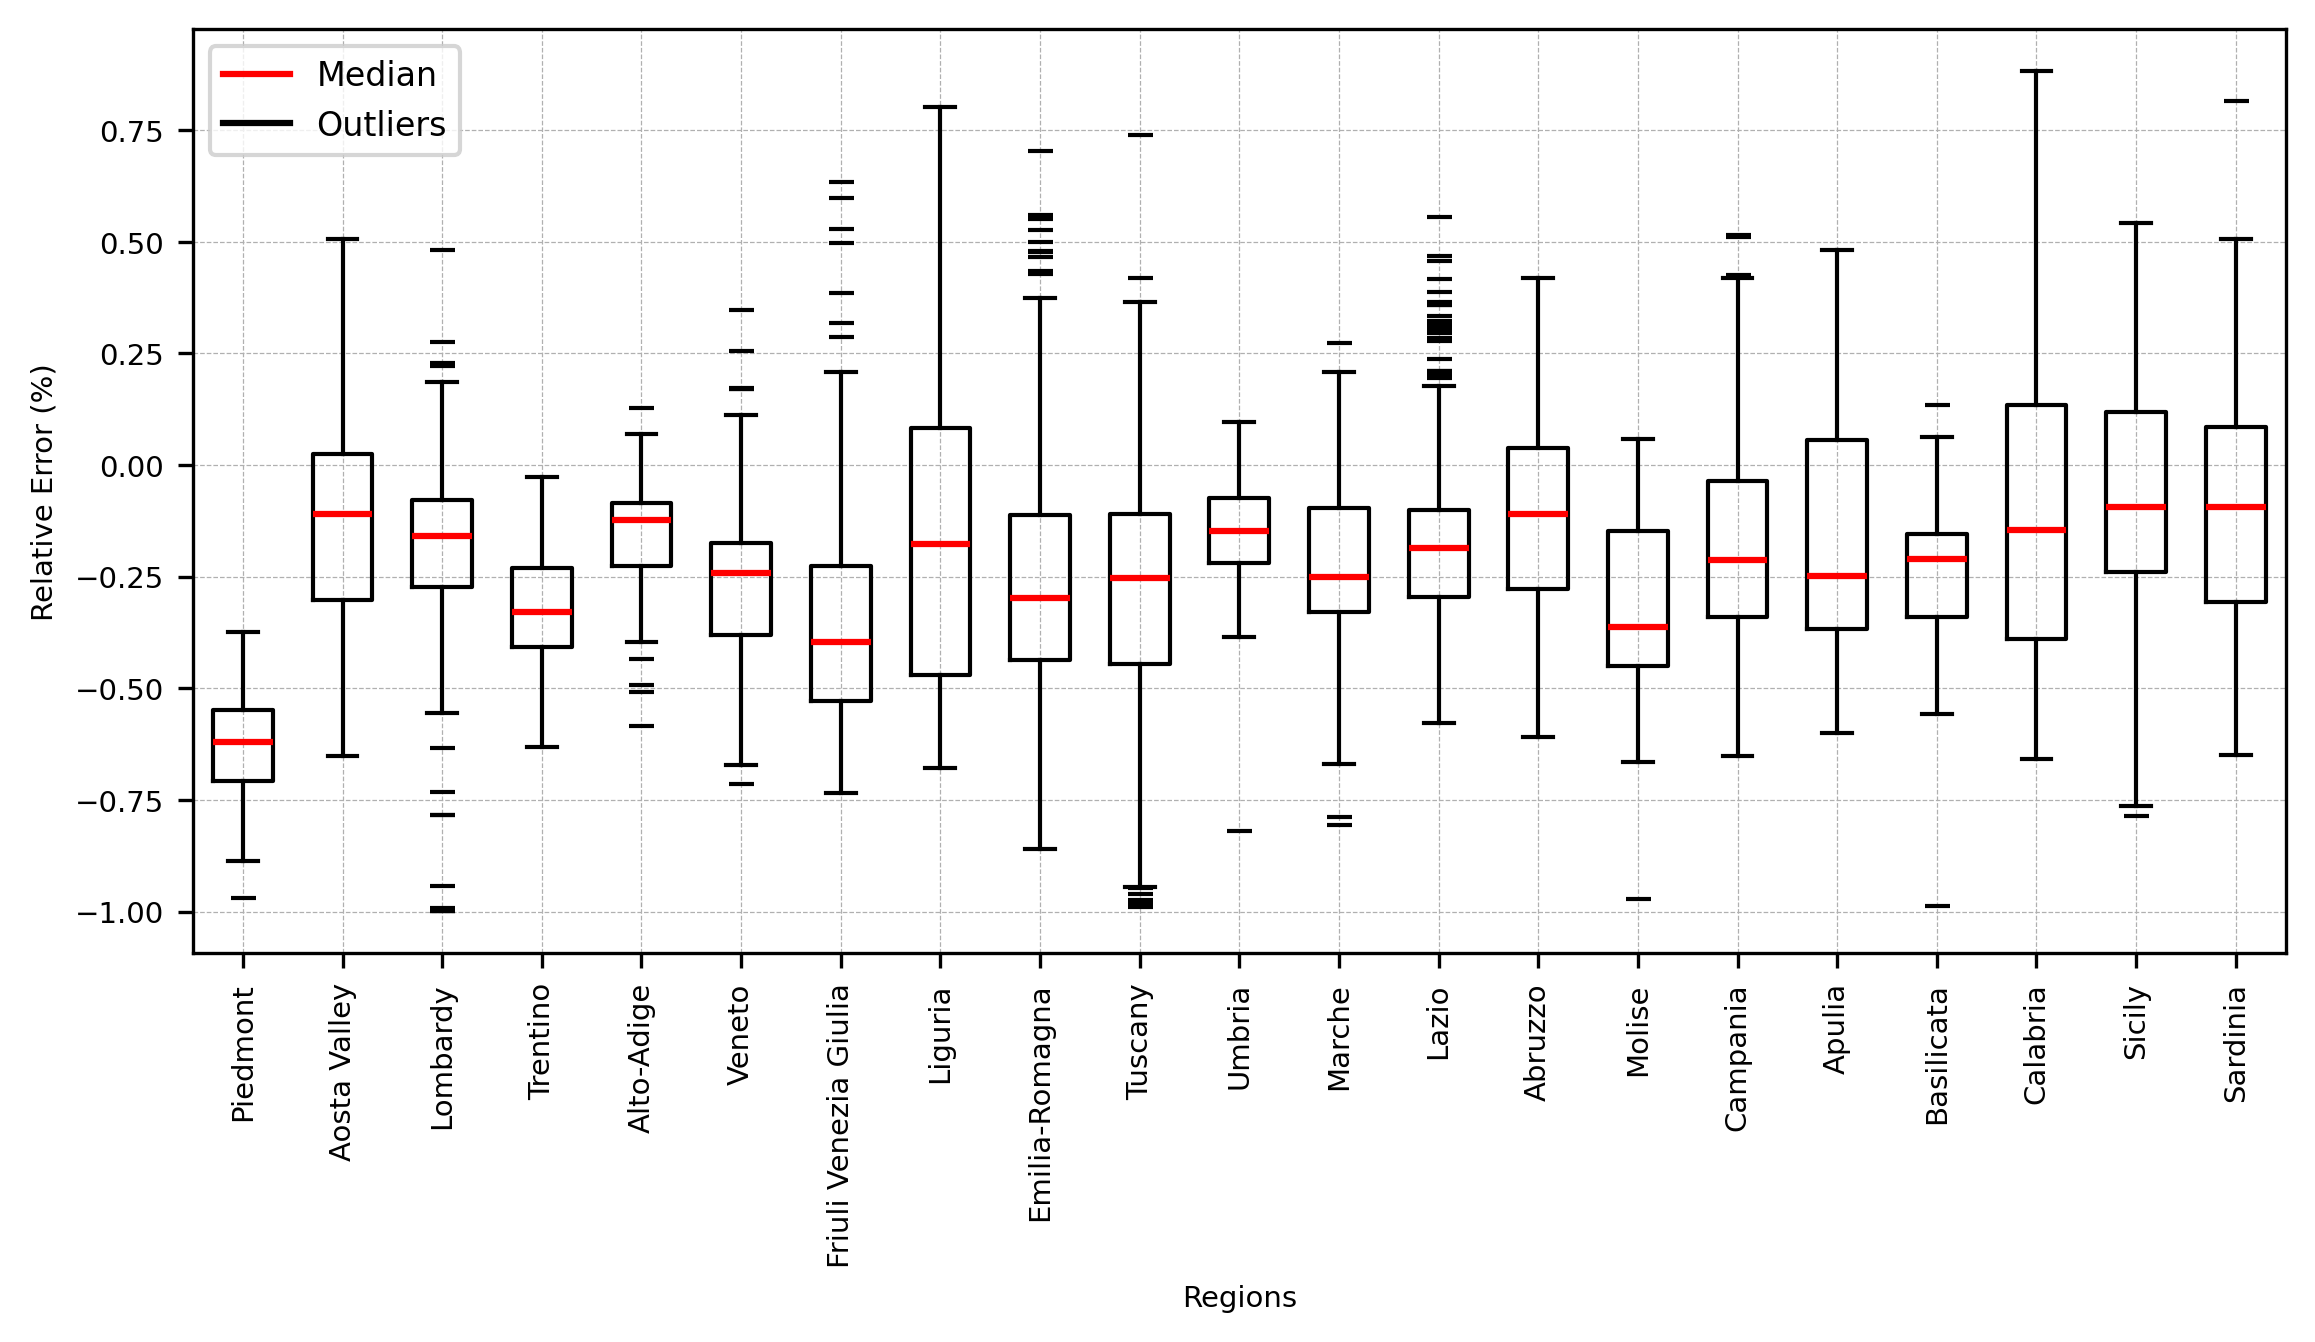

In [16]:
fig = plt.figure(figsize=(9,4),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0])

flierprops = dict(marker='_', markersize=6, markeredgecolor='k')
medianprops = dict(linestyle='-', linewidth=1.5, color='r')

for pos in range(len(dict_keys)):
    ax1.boxplot(diccionario_resultados[dict_keys[pos]],positions=[pos], widths=0.6, flierprops=flierprops, medianprops=medianprops)

ax1.plot([],[],linestyle='-',c='r',label='Median')
ax1.plot([],[],linestyle='-',c='k',label='Outliers')

ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.set_xticklabels(ISO_names['REGION'].values, rotation='vertical')

ax1.grid(linewidth=0.3, linestyle='--')
ax1.legend(fontsize=8, loc=0, ncol=1)

ax1.set_ylabel('Relative Error (%)', fontsize=7)
ax1.set_xlabel('Regions', fontsize=7)

In [17]:
region_mean = []
for pos in range(len(dict_keys)):
    region_mean.append(float(np.nanmean(df_resultados[dict_keys[pos]])))

(-0.7, 0.0)

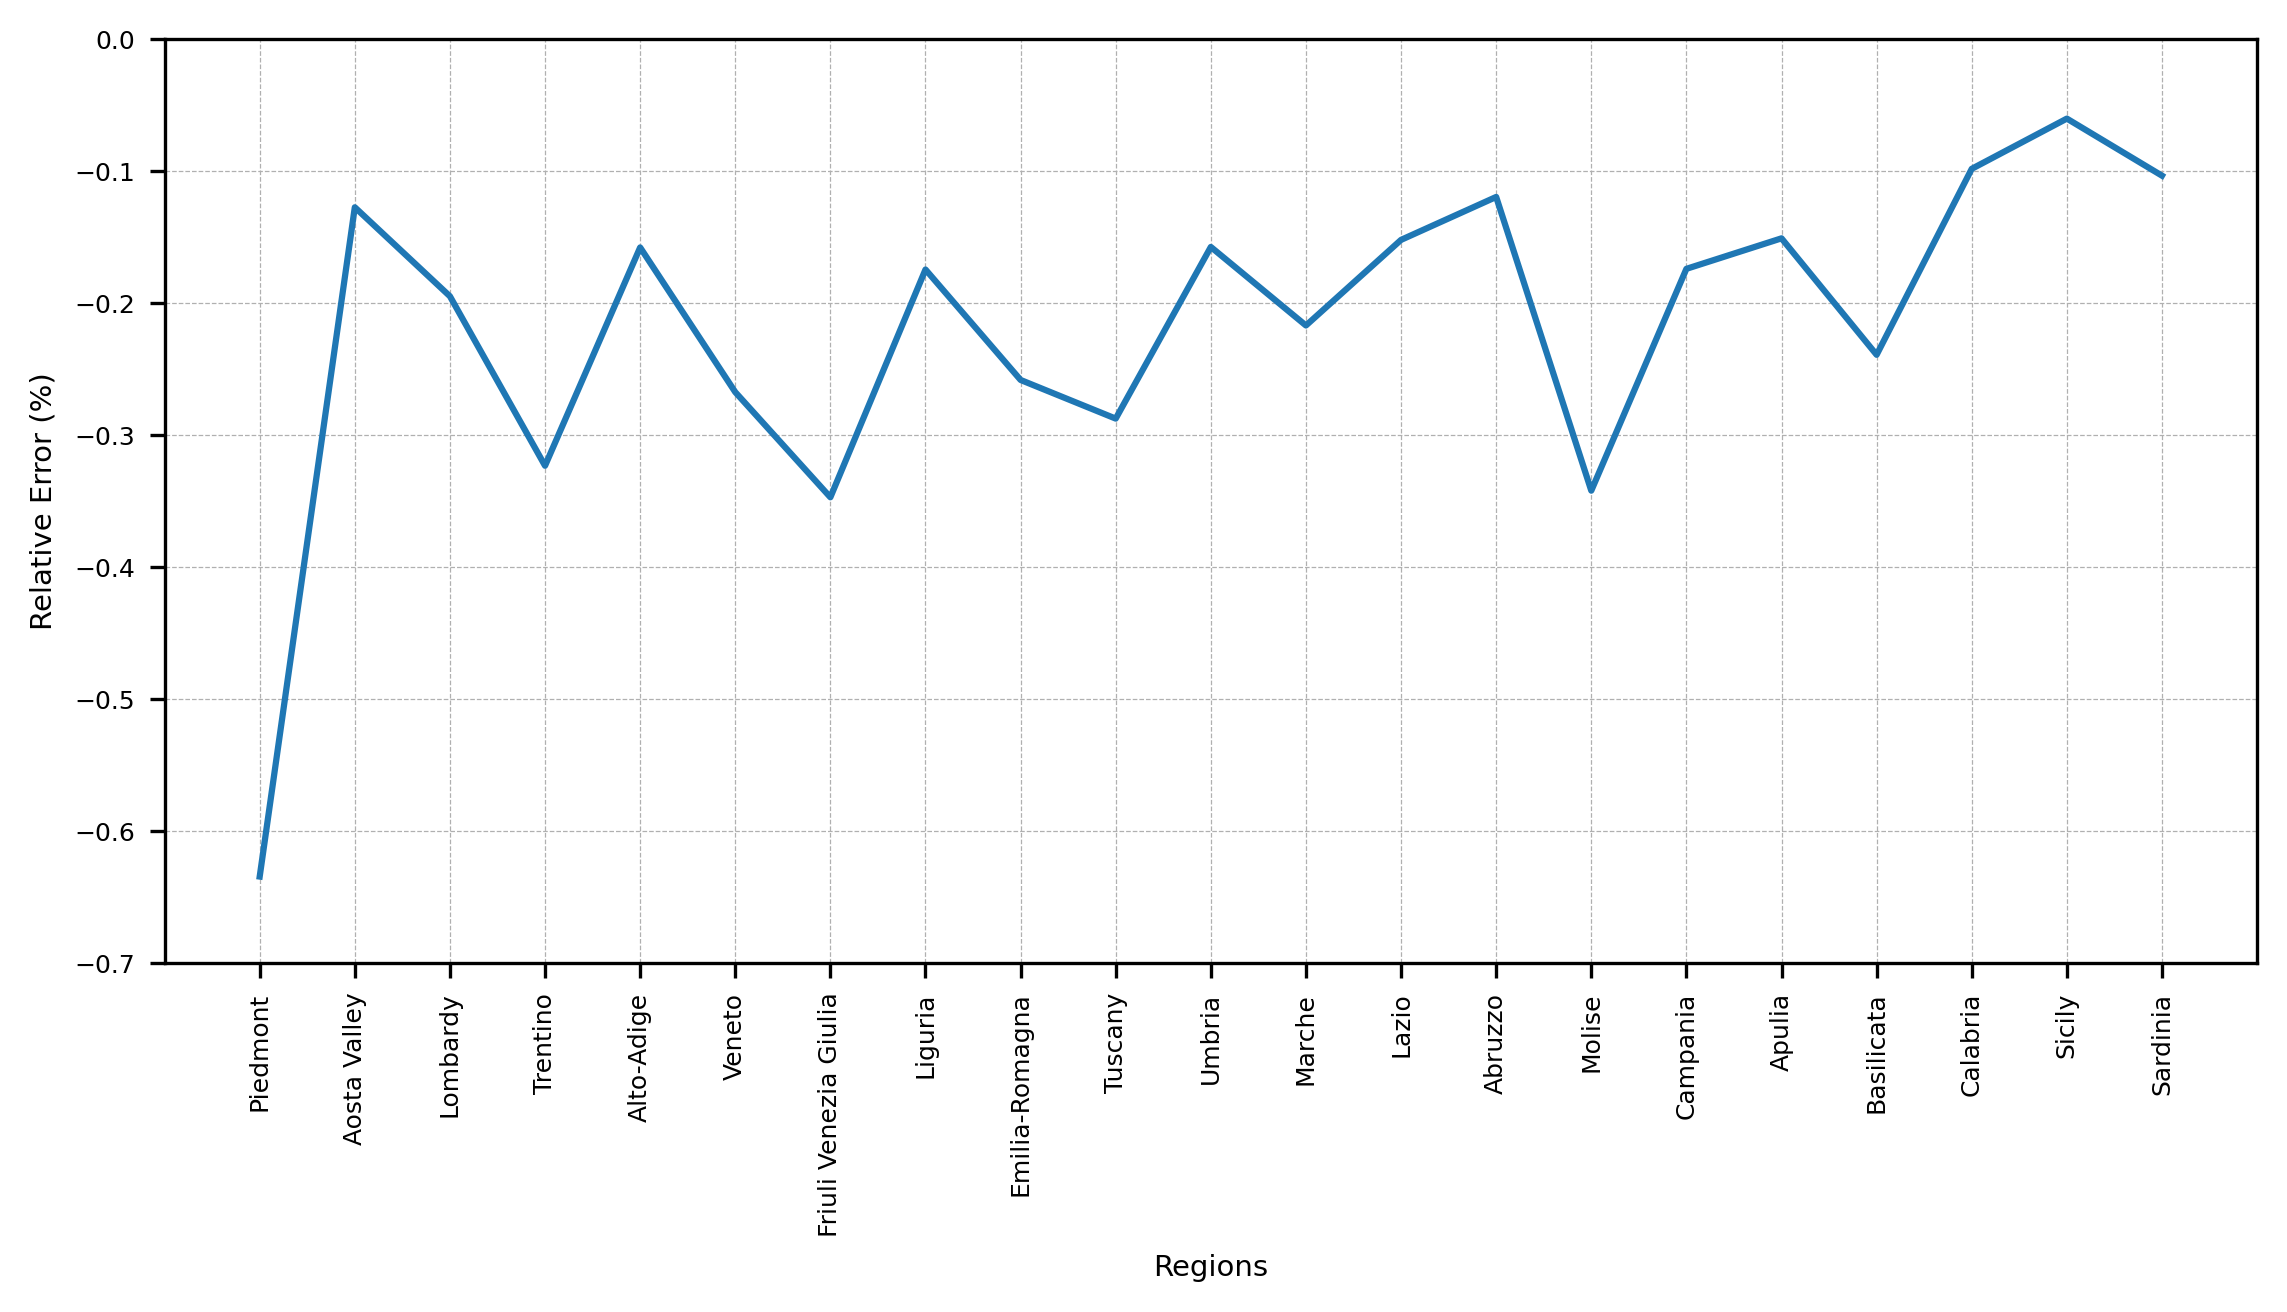

In [18]:
xpos = np.arange(len(ISO_names['REGION'].values))

fig = plt.figure(figsize=(9,4),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(xpos, region_mean)

ax1.tick_params(axis='both', which='major', labelsize=6)

ax1.set_xticks(xpos)
ax1.set_xticklabels(ISO_names['REGION'].values, rotation='vertical')

ax1.grid(linewidth=0.3, linestyle='--')

ax1.set_ylabel('Relative Error (%)', fontsize=7)
ax1.set_xlabel('Regions', fontsize=7)

ax1.set_ylim(-0.7,0)

In [19]:
MEAN_norm = mcolors.Normalize(vmin=min(ISO_names["mean"]), vmax=max(ISO_names["mean"]))
MEAN_vals = (ISO_names["mean"]-np.nanmin(ISO_names["mean"]))/(np.nanmax(ISO_names["mean"])-np.nanmin(ISO_names["mean"]))
MEAN_colors = [(250/255, 128/255, 114/255, alpha) for alpha in sorted(MEAN_vals,reverse=True)]
MEAN_cmap = mcolors.ListedColormap(MEAN_colors)

MAX_norm = mcolors.Normalize(vmin=min(ISO_names["max"]), vmax=max(ISO_names["max"]))
MAX_vals = (ISO_names["max"]-np.nanmin(ISO_names["max"]))/(np.nanmax(ISO_names["max"])-np.nanmin(ISO_names["max"]))
MAX_colors = [(250/255, 128/255, 114/255, alpha) for alpha in sorted(MAX_vals,reverse=False)]
MAX_cmap = mcolors.ListedColormap(MAX_colors)

MIN_norm = mcolors.Normalize(vmin=min(ISO_names["min"]), vmax=max(ISO_names["min"]))
MIN_vals = (ISO_names["min"]-np.nanmin(ISO_names["min"]))/(np.nanmax(ISO_names["min"])-np.nanmin(ISO_names["min"]))
MIN_colors = [(250/255, 128/255, 114/255, alpha) for alpha in sorted(MIN_vals,reverse=True)]
MIN_cmap = mcolors.ListedColormap(MIN_colors)

In [20]:
new_max = abs(ISO_names['max'])
new_max[new_max>1]=1

In [21]:
for geo_n in range(20):
    print(f'Geometry: {REGIONS['reg_name'][geo_n]}')
    print(f'ISO     : {ISO_names['REGION'][geo_n]}')
    print()

Geometry: Piedmont
ISO     : Piedmont

Geometry: Aosta Valley
ISO     : Aosta Valley

Geometry: Lombardy
ISO     : Lombardy

Geometry: Trentino
ISO     : Trentino

Geometry: Veneto
ISO     : Alto-Adige

Geometry: Friuli Venezia Giulia
ISO     : Veneto

Geometry: Liguria
ISO     : Friuli Venezia Giulia

Geometry: Emilia-Romagna
ISO     : Liguria

Geometry: Tuscany
ISO     : Emilia-Romagna

Geometry: Umbria
ISO     : Tuscany

Geometry: Marche
ISO     : Umbria

Geometry: Lazio
ISO     : Marche

Geometry: Abruzzo
ISO     : Lazio

Geometry: Molise
ISO     : Abruzzo

Geometry: Campania
ISO     : Molise

Geometry: Apulia
ISO     : Campania

Geometry: Basilicata
ISO     : Apulia

Geometry: Calabria
ISO     : Basilicata

Geometry: Sicily
ISO     : Calabria

Geometry: Sardinia
ISO     : Sicily



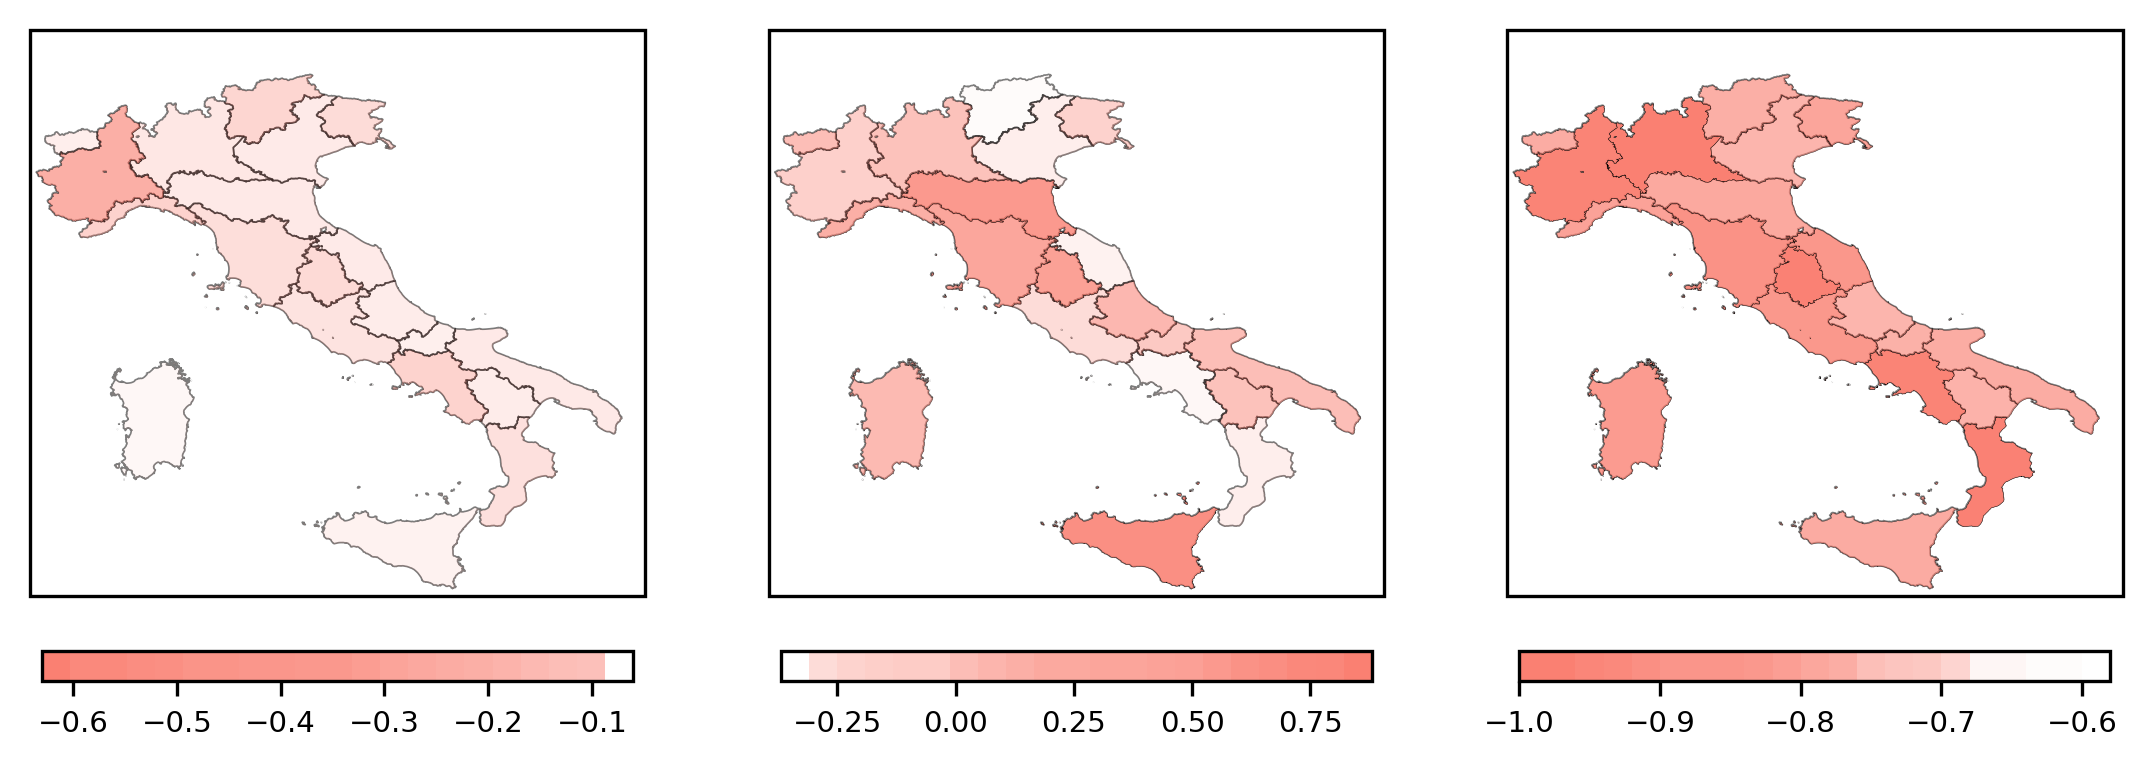

In [22]:
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(9,4),dpi=300)
gs = gridspec.GridSpec(1,3)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.add_geometries(REGIONS.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.4, alpha=0.5)

for geo_n in range(20):
    ax1.add_geometries(REGIONS['geometry'][geo_n], ccrs.PlateCarree(), edgecolor='k', facecolor='salmon', linewidth=0.1, alpha=abs(ISO_names['mean'][geo_n]))

sm_lombardia = ScalarMappable(cmap=MEAN_cmap, norm=MEAN_norm)
sm_lombardia.set_array([])
cbar_lombardia = plt.colorbar(sm_lombardia, ax=ax1, fraction=0.032, pad=0.06, orientation='horizontal')
cbar_lombardia.ax.tick_params(labelsize=7) 

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.add_geometries(REGIONS.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.4, alpha=0.5)

for geo_n in range(20):
    ax1.add_geometries(REGIONS['geometry'][geo_n], ccrs.PlateCarree(), edgecolor='k', facecolor='salmon', linewidth=0.1, alpha=new_max[geo_n])

sm_lombardia = ScalarMappable(cmap=MAX_cmap, norm=MAX_norm)
sm_lombardia.set_array([])
cbar_lombardia = plt.colorbar(sm_lombardia, ax=ax1, fraction=0.032, pad=0.06, orientation='horizontal')
cbar_lombardia.ax.tick_params(labelsize=7) 

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.add_geometries(REGIONS.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.4, alpha=0.5)

for geo_n in range(20):
    ax1.add_geometries(REGIONS['geometry'][geo_n], ccrs.PlateCarree(), edgecolor='k', facecolor='salmon', linewidth=0.1, alpha=abs(ISO_names['min'][geo_n]))

sm_lombardia = ScalarMappable(cmap=MIN_cmap, norm=MIN_norm)
sm_lombardia.set_array([])
cbar_lombardia = plt.colorbar(sm_lombardia, ax=ax1, fraction=0.032, pad=0.06, orientation='horizontal')
cbar_lombardia.ax.tick_params(labelsize=7) 